<a href="https://colab.research.google.com/github/liuxb555/earthengine-py-examples/blob/master/FFC_EXE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

实现功能：

（1）导入自己训练好的模型

（2）建立所需的数据集格式

> a. 6个波段加NDVI

> b. 

（3）能够指定影像进行输出

In [5]:
# If not on Colab you'll need install the earth-engine Python API
#!pip install earthengine-api #earth-engine Python API

# Athenticate to your GEE account. 
!earthengine authenticate

# Earth Engine Python API
import ee 
ee.Initialize()

Instructions for updating:
non-resource variables are not supported in the long term
To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=rH3IkLAsBkbXQK0k1i4hn3bTvK7K1N_dRCGbjUsijnE&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AY0e-g7jsIXZCmy7MY8BMyj6QIupSvVDighHAIJ9ZDcOOaqyfDeXAslA83Q

Successfully saved authorization token.


In [6]:
# Connect Google Drive  注意，每次打开新的Colab Notebook都需要重新关联。
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


首先导入所需的库（不确定哪些需要，凭感觉导入）

In [7]:
#install python packages to run this notebook 
!pip install -q rasterio rasterstats geopandas lightgbm

     |████████████████████████████████| 19.1MB 1.3MB/s 
     |████████████████████████████████| 1.0MB 34.1MB/s 
     |████████████████████████████████| 133kB 39.0MB/s 
     |████████████████████████████████| 15.3MB 152kB/s 
     |████████████████████████████████| 6.5MB 47.2MB/s 


In [11]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

import lightgbm as lgb

import rasterio
import rasterstats
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import os
import pickle
from pickle import dump, load
from os import path as op

import rasterio
from rasterio.features import rasterize
from rasterstats.io import bounds_window

from IPython.display import Image
import folium


In [18]:
root_dir = ('/content/drive/MyDrive/Colab Notebooks/FFC_EXE')
model_name = op.join(root_dir, 'Bands_NDVI_LGBM_GEE_EXE_model.sav')  # 这个模型是6个波段加一个ndvi（只是作为测试模型）

def band_index(arr, a, b):
    # print(arr)   
    arr = arr * 0.0001 
    return np.expand_dims((arr[..., a] - arr[..., b]) / (arr[..., a] + arr[..., b]), axis=1)

lgbm = pickle.load(open(op.join(root_dir, model_name), 'rb'))  # 加载模型
lgbm

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [63]:
%%time
# 该代码的理解
# 由于计算资源的限制,不能计算无限大的数据集,本代码将数据集按照一定的尺寸分割后进行计算,原代码中提供的尺寸是size = 500.目前尝试了size=5000,仍然可以计算.
# 但是代码还存在以下几个问题需要解决
# |-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|
# 该代码存在的问题: (1) 对于空值的解决,代码中使用去除空值后的数据的shape,可不可以将空值填充??? 涉及到的函数:numpy.ma.masked_invalid(a, copy=True); ~m.mask

#           (2) 植被指数的计算,目前不能直接用公式计算?????
#           ----- 已经解决: 参考 https://blog.csdn.net/qq_40643699/article/details/107985401
#               如果直接使用公式计算:NDVI = (NIR-Red)/(NIR+Red),生成的NDVI的形状NDVI.shape为(n,),若改为NDVI = np.expand_dims((NIR-Red)/(NIR+Red),axis=1)时,此时的NDVI的形状NDVI.shape为(n,1)
#               其中np.expand_dims:用于扩展数组的形状
#               np.expand_dims(a, axis=0)表示在0位置添加数据
#               np.expand_dims(a, axis=1)表示在1位置添加数据
#               eg.
#           (3) 结果输出的时候,不能出图?????
#           ----- 已经解决:
#               原代码中设置的数据格式为uint8,但是我的数据输出为float,因此将我的数据格式修改为uint8类型,


area = ee.FeatureCollection('users/liuxb555/GEE_EXE')

# open connections to our input and output images

# new_image = op.join(root_dir, 'Trans_nzoia_2019_10-04.tif')
raster_file = '/content/drive/Shareddrives/liuxb555@gmail.com/l8Imgs_select.tif'  #l8Imgs_select.tif l8Imgs_EXE_iMAGE   l8Imgs_select-0000000000-0000056832.tif
new_image = raster_file
output_image = op.join(root_dir, "lgbm_predicted.tif")

with rasterio.open(new_image, 'r') as src:
  profile = src.profile
  profile.update(dtype=rasterio.uint8,count=1)

  with rasterio.open(output_image, 'w', **profile) as dst: 

    # perform prediction on each small image patch to minimize required memory
    patch_size = 10000

    print('src.shape',src.shape)
    print('((src.shape[0] // patch_size) + 1)',((src.shape[0] // patch_size) + 1))
    print('((src.shape[1] // patch_size) + 1)',((src.shape[1] // patch_size) + 1))

    for i in range((src.shape[0] // patch_size) + 1):
        for j in range((src.shape[1] // patch_size) + 1):
            # define the pixels to read (and write)
            window = rasterio.windows.Window(
                j * patch_size,
                i * patch_size,
                # don't read past the image bounds
                min(patch_size, src.shape[1] - j * patch_size),
                min(patch_size, src.shape[0] - i * patch_size)
            )
            # print('window',window)

            data = src.read(window=window)
            data = 0.0001 * data
            
            # print('data.shape',data.shape)
            # read the image into the proper format, adding indices if necessary
            img_swp = np.moveaxis(data, 0, 2)
            # img_swp = (img_swp[:,:,1:7])
            # print('img_swp.shape',img_swp.shape[0],img_swp.shape[1],img_swp.shape[2])
            # print('(img_swp[:,:,1:7]).shape',(img_swp[:,:,1:7]).shape)

            img_flat = img_swp.reshape(-1, img_swp.shape[-1])
            # print('img_flat.shape',img_flat.shape)
            # img_flat = img_flat
            # print('img_flat.shape',img_flat)

            # landsat8: NDWI = (band3 - band5) / (band3 + band5)
            # landsat5/7: NDWI = (band2 - band4) / (band2 + band4)
            # img_ndvi = band_index(img_flat, 4, 3)
            # print('img_ndvi.shape',img_ndvi.shape)
            # img_ndwi = band_index(img_flat, 4, 2)

            Blue = img_flat[:,0] #[:,-1]
            Green = img_flat[:,1]
            Red = img_flat[:,2]
            NIR = img_flat[:,3]
            SWIR_1 = img_flat[:,4]
            SWIR_2 = img_flat[:,5]
            # SWIR_3 = img_flat[:,:6]

            # print("B2.shape","B3.shape","B4.shape","B5.shape","B6.shape","B7.shape",Blue.shape,Green.shape,Red.shape,NIR.shape,SWIR_1.shape,SWIR_2.shape)
            # print(Blue) 
            # print(Green)
            # print(Red)
            # print(NIR)
            # print(SWIR_1)
            # print(SWIR_2)
            img_ndvi = np.expand_dims((NIR - Red) / (NIR + Red), axis=1)   ## ？？？？ NDVI 的计算？？？？
            print('img_ndvi_.shape',img_ndvi.shape)

            img_w_ind = np.concatenate([img_flat, img_ndvi], axis=1)
            print('img_w_ind.shape',img_w_ind.shape)
            # print('img_w_ind.shape[-1]',img_w_ind.shape[-1])

            # remove no_data values, store the indices for later use
            # a later cell makes the assumption that all bands have identical no-data value arrangements
            m = np.ma.masked_invalid(img_w_ind)    # ！！！！numpy.ma.masked_invalid(a, copy=True) ！！！！！ 屏蔽发生无效值(NaNs或infs)的数组。
            # print(m)
            # print('m.shape',m.shape)
            # print('~m.mask',~m.mask)
            
            # to_predict = img_w_ind[~m.mask].reshape(-1, img_w_ind.shape[-1])   ##？？？？？这一步不太懂，好像是将屏蔽后的数组reshape
            # print('to_predict',to_predict)
                        
            to_predict = img_w_ind   ####   不执行屏蔽命令,直接可以估算,但是假如数组中存在空值
            # print('to_predict',to_predict)

            if not len(to_predict):
                continue
            img_preds = lgbm.predict(to_predict)
            print('img_preds',img_preds)
            img_preds = img_preds*100
            
            # add the prediction back to the valid pixels (using only the first band of the mask to decide on validity)
            # resize to the original image dimensions
            output = np.zeros(img_flat.shape[0])
            output[~m.mask[:,0]] = img_preds.flatten()
            output = output.reshape(*img_swp.shape[:-1])
            
            # create our final mask
            mask = (~m.mask[:,0]).reshape(*img_swp.shape[:-1])

            # write to the final file
            dst.write(output.astype(rasterio.uint8), 1, window=window)  ## uint8:这个数据单位需要修改,生成的数据的格式是float
            dst.write_mask(mask, window=window)
            # write to the final file
            dst.write(output.astype(rasterio.uint8), 1, window=window)
            dst.write_mask(mask, window=window)

            # print(dst)???????/




src.shape (1068, 1069)
((src.shape[0] // patch_size) + 1) 1
((src.shape[1] // patch_size) + 1) 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:83: RuntimeWarning: divide by zero encountered in true_divide


img_ndvi_.shape (1141692, 1)
img_w_ind.shape (1141692, 7)
img_preds [0.41985873 0.45018628 0.45018628 ... 0.13219729 0.13219729 0.12833439]
CPU times: user 6.63 s, sys: 447 ms, total: 7.08 s
Wall time: 4.29 s


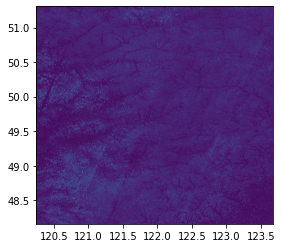

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


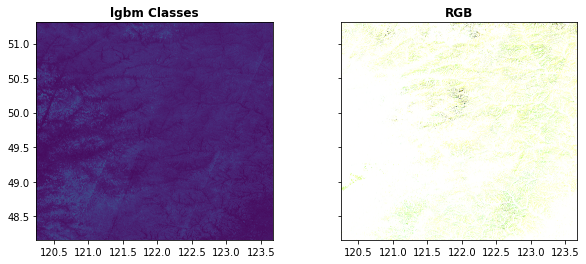

In [62]:
import matplotlib.pyplot as plt
from rasterio.plot import show
%matplotlib inline


# Load the classification
if os.path.exists(op.join(root_dir, "lgbm_predicted.tif")):
  output_image = op.join(root_dir, "lgbm_predicted.tif")
else:
  # output_image = '/content/drive/Shared drives/servir-sat-ml/data/lgbm_classification.tif'
  output_image = '/content/drive/MyDrive/Colab Notebooks/data/lgbm_predicted.tif'

# def linear_rescale(image, in_range=(0, 1), out_range=(1, 255)):
#     imin, imax = in_range
#     omin, omax = out_range
#     image = np.clip(image, imin, imax) - imin
#     image = image / np.float(imax - imin)
#     return image * (omax - omin) + omin

with rasterio.open(output_image, 'r') as class_raster:
  show(class_raster)
  lgbm_classes = class_raster.read()


# Load the original image
with rasterio.open(raster_file, 'r') as s2_raster:
#  show(s2_raster)
  s2 = s2_raster.read([1,2,3])

# Compare side by side
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(10, 4), sharey=True)
show(lgbm_classes, transform=class_raster.transform, ax=ax1, title="lgbm Classes")
show(s2[[2,1,0], : , :], transform=s2_raster.transform, adjust='linear', ax=ax2, title="RGB")

In [ ]:
# %%time

# 保存副本
# # 该代码的理解
# # 由于计算资源的限制,不能计算无限大的数据集,本代码将数据集按照一定的尺寸分割后进行计算,原代码中提供的尺寸是size = 500.目前尝试了size=5000,仍然可以计算.
# # 但是代码还存在以下几个问题需要解决
# # |-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|-|
# # 该代码存在的问题: (1) 对于空值的解决,代码中使用去除空值后的数据的shape,可不可以将空值填充??? 涉及到的函数:numpy.ma.masked_invalid(a, copy=True); ~m.mask

# #           (2) 植被指数的计算,目前不能直接用公式计算?????

# #           (3) 结果输出的时候,不能出图?????
# #           ----- 已经解决:原代码中设置的数据格式为uint8,但是我的数据输出为float,因此将我的数据格式修改为uint8类型,


# area = ee.FeatureCollection('users/liuxb555/GEE_EXE')

# # open connections to our input and output images

# # new_image = op.join(root_dir, 'Trans_nzoia_2019_10-04.tif')
# raster_file = '/content/drive/Shareddrives/liuxb555@gmail.com/l8Imgs_EXE_iMAGE.tif'  #l8Imgs_select.tif l8Imgs_EXE_iMAGE   l8Imgs_select-0000000000-0000056832.tif
# new_image = raster_file
# output_image = op.join(root_dir, "lgbm_predicted.tif")

# with rasterio.open(new_image, 'r') as src:
#   profile = src.profile
#   profile.update(dtype=rasterio.uint8,count=1)

#   with rasterio.open(output_image, 'w', **profile) as dst: 

#     # perform prediction on each small image patch to minimize required memory
#     patch_size = 10000

#     print('src.shape',src.shape)
#     print('((src.shape[0] // patch_size) + 1)',((src.shape[0] // patch_size) + 1))
#     print('((src.shape[1] // patch_size) + 1)',((src.shape[1] // patch_size) + 1))

#     for i in range((src.shape[0] // patch_size) + 1):
#         for j in range((src.shape[1] // patch_size) + 1):
#             # define the pixels to read (and write)
#             window = rasterio.windows.Window(
#                 j * patch_size,
#                 i * patch_size,
#                 # don't read past the image bounds
#                 min(patch_size, src.shape[1] - j * patch_size),
#                 min(patch_size, src.shape[0] - i * patch_size)
#             )
#             # print('window',window)

#             data = src.read(window=window)
#             data = 0.0001 * data
            
#             # print('data.shape',data.shape)
#             # read the image into the proper format, adding indices if necessary
#             img_swp = np.moveaxis(data, 0, 2)
#             # img_swp = (img_swp[:,:,1:7])
#             # print('img_swp.shape',img_swp.shape[0],img_swp.shape[1],img_swp.shape[2])
#             # print('(img_swp[:,:,1:7]).shape',(img_swp[:,:,1:7]).shape)

#             img_flat = img_swp.reshape(-1, img_swp.shape[-1])
#             # print('img_flat.shape',img_flat.shape)
#             # img_flat = img_flat
#             # print('img_flat.shape',img_flat)

#             # landsat8: NDWI = (band3 - band5) / (band3 + band5)
#             # landsat5/7: NDWI = (band2 - band4) / (band2 + band4)
#             img_ndvi = band_index(img_flat, 4, 3)
#             # print('img_ndvi.shape',img_ndvi.shape)
#             # img_ndwi = band_index(img_flat, 4, 2)

#             Blue = img_flat[:,0] #[:,-1]
#             Green = img_flat[:,1]
#             Red = img_flat[:,2]
#             NIR = img_flat[:,3]
#             SWIR_1 = img_flat[:,4]
#             SWIR_2 = img_flat[:,5]
#             # SWIR_3 = img_flat[:,:6]

#             # print("B2.shape","B3.shape","B4.shape","B5.shape","B6.shape","B7.shape",Blue.shape,Green.shape,Red.shape,NIR.shape,SWIR_1.shape,SWIR_2.shape)
#             # print(Blue) 
#             # print(Green)
#             # print(Red)
#             # print(NIR)
#             # print(SWIR_1)
#             # print(SWIR_2)
#             # img_ndvi = np.expand_dims((NIR - Red) / (NIR + Red), axis=1)   ## ？？？？ NDVI 的计算？？？？
#             # print('img_ndvi_.shape',img_ndvi.shape)

#             img_w_ind = np.concatenate([img_flat, img_ndvi], axis=1)
#             print('img_w_ind.shape',img_w_ind.shape)
#             # print('img_w_ind.shape[-1]',img_w_ind.shape[-1])

#             # remove no_data values, store the indices for later use
#             # a later cell makes the assumption that all bands have identical no-data value arrangements
#             m = np.ma.masked_invalid(img_w_ind)    # ！！！！numpy.ma.masked_invalid(a, copy=True) ！！！！！ 屏蔽发生无效值(NaNs或infs)的数组。
#             # print(m)
#             # print('m.shape',m.shape)
#             # print('~m.mask',~m.mask)
            
#             # to_predict = img_w_ind[~m.mask].reshape(-1, img_w_ind.shape[-1])   ##？？？？？这一步不太懂，好像是将屏蔽后的数组reshape
#             # print('to_predict',to_predict)
                        
#             to_predict = img_w_ind   ####   不执行屏蔽命令,直接可以估算,但是假如数组中存在空值
#             # print('to_predict',to_predict)

#             if not len(to_predict):
#                 continue
#             img_preds = lgbm.predict(to_predict)
#             print('img_preds',img_preds)
#             img_preds = img_preds*100
            
#             # add the prediction back to the valid pixels (using only the first band of the mask to decide on validity)
#             # resize to the original image dimensions
#             output = np.zeros(img_flat.shape[0])
#             output[~m.mask[:,0]] = img_preds.flatten()
#             output = output.reshape(*img_swp.shape[:-1])
            
#             # create our final mask
#             mask = (~m.mask[:,0]).reshape(*img_swp.shape[:-1])

#             # write to the final file
#             dst.write(output.astype(rasterio.uint8), 1, window=window)  ## uint8:这个数据单位需要修改,生成的数据的格式是float
#             dst.write_mask(mask, window=window)
#             # write to the final file
#             dst.write(output.astype(rasterio.uint8), 1, window=window)
#             dst.write_mask(mask, window=window)

#             # print(dst)???????/




In [ ]:
# 小范围的可以 https://gis.stackexchange.com/questions/350771/earth-engine-simplest-way-to-move-from-ee-image-to-array-for-use-in-sklearn/351177#351177

import ee
import numpy as np

# Define an image.
img = ee.Image('LANDSAT/LC08/C01/T1_SR/LC08_038029_20180810').select(['B4', 'B5', 'B6'])

# Define an area of interest.
aoi = ee.Geometry.Polygon(
  [[[-110.8, 44.7],
    [-110.8, 44.6],
    [-110.6, 44.6],
    [-110.6, 44.7]]], None, False)

# Get 2-d pixel array for AOI - returns feature with 2-D pixel array as property per band.
band_arrs = img.sampleRectangle(region=aoi)

# Get individual band arrays.
band_arr_b4 = band_arrs.get('B4')
band_arr_b5 = band_arrs.get('B5')
band_arr_b6 = band_arrs.get('B6')

# Transfer the arrays from server to client and cast as np array.
np_arr_b4 = np.array(band_arr_b4.getInfo())
np_arr_b5 = np.array(band_arr_b5.getInfo())
np_arr_b6 = np.array(band_arr_b6.getInfo())
print(np_arr_b4.shape)
print(np_arr_b5.shape)
print(np_arr_b6.shape)

# Expand the dimensions of the images so they can be concatenated into 3-D.
np_arr_b4 = np.expand_dims(np_arr_b4, 2)
np_arr_b5 = np.expand_dims(np_arr_b5, 2)
np_arr_b6 = np.expand_dims(np_arr_b6, 2)
print(np_arr_b4.shape)
print(np_arr_b5.shape)
print(np_arr_b6.shape)

# Stack the individual bands to make a 3-D array.
rgb_img = np.concatenate((np_arr_b6, np_arr_b5, np_arr_b4), 2)
print(rgb_img.shape)

# Scale the data to [0, 255] to show as an RGB image.
rgb_img_test = (255*((rgb_img - 100)/3500)).astype('uint8')
plt.imshow(rgb_img_test)
plt.show()

In [ ]:
# https://gis.stackexchange.com/questions/285779/use-google-earth-engine-to-read-modis-ndvi-into-python

import ee 
import numpy as np

date_start = ee.Date('2004-05-01')
end_date = ee.Date('2004-06-12')

# area = ee.FeatureCollection(r'users/bcoerver/gadm36_PSE_0')

# define the image
img = ee.ImageCollection('MODIS/MCD43A4_006_NDVI').filterDate(date_start, end_date)

median_data = img.median()

# get the lat lon and add the ndvi
latlon = ee.Image.pixelLonLat().addBands(median_data)

# apply reducer to list
latlon = latlon.reduceRegion(reducer=ee.Reducer.toList(),
  geometry=area,
  maxPixels = 1e13,
  scale=30);

# get data into three different arrays
data = np.array((ee.Array(latlon.get("NDVI")).getInfo()))
lats = np.array((ee.Array(latlon.get("latitude")).getInfo()))
lons = np.array((ee.Array(latlon.get("longitude")).getInfo()))

data.shape,data

In [ ]:
#Define a region of interest as a point and buffer 1km around the area
roi = ee.Geometry.Point([-124.0769, 40.1035]).buffer(1000)

#Get Image from Landsat

image = ee.Image(ee.ImageCollection('LANDSAT/LC08/C01/T1_RT').filterDate('2014-01-01', '2014-01-01').filterBounds(roi))

#Function from https://gis.stackexchange.com/q/360278

def meanNDVICollection (img,aoi):
  nir = img.select('B5')
  red = img.select('B4')
  ndviImage = nir.subtract(red).divide(nir.add(red)).rename('NDVI')

  # Compute the mean of NDVI over the 'region'
  ndviValue = ndviImage.reduceRegion(**{
    'geometry': aoi.getInfo(),
    'reducer': ee.Reducer.mean(),
  }).get('NDVI');  # result of reduceRegion is always a dictionary, so get the element we want

  newFeature = ee.Feature(None, {
      # Adding computed NDVI value
      'NDVI': ndviValue
  }).copyProperties(img, [
      # Picking properties from original image
      'system:time_start'
  ])

  return newFeature
meanNDVICollection(image,aoi)



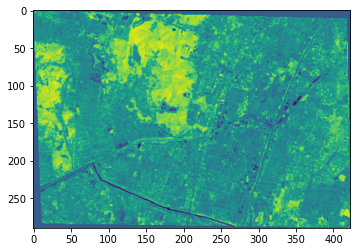

AttributeError: ignored

In [ ]:
# https://mygeoblog.com/2017/10/06/from-gee-to-numpy-to-geotiff/

import ee
import numpy as np
from osgeo import gdal
from osgeo import osr
import time
 
# # init the ee object
# ee.Initialize()
 
# Define the area
area = ee.Geometry.Polygon([[[105.532,19.059],[105.606,19.058],[105.605,19.108],[105.530,19.110],[105.532,19.059]]])
 
# define the image
img = ee.Image("COPERNICUS/S2/20160209T034234_20160209T090731_T48QWG")
 
# do any ee operation here
ndvi = ee.Image(img.normalizedDifference(['B8', 'B4']))
timedate = img.get('GENERATION_TIME').getInfo()
 
# get the lat lon and add the ndvi
latlon = ee.Image.pixelLonLat().addBands(ndvi)
 
# apply reducer to list
latlon = latlon.reduceRegion(
  reducer=ee.Reducer.toList(),
  geometry=area,
  maxPixels=1e8,
  scale=20);
 
 
# get data into three different arrays
data = np.array((ee.Array(latlon.get("nd")).getInfo()))
lats = np.array((ee.Array(latlon.get("latitude")).getInfo()))
lons = np.array((ee.Array(latlon.get("longitude")).getInfo()))
 
# get the unique coordinates
uniqueLats = np.unique(lats)
uniqueLons = np.unique(lons)
 
# get number of columns and rows from coordinates
ncols = len(uniqueLons)    
nrows = len(uniqueLats)
 
# determine pixelsizes
ys = uniqueLats[1] - uniqueLats[0] 
xs = uniqueLons[1] - uniqueLons[0]
 
# create an array with dimensions of image
arr = np.zeros([nrows, ncols], np.float32) #-9999
 
# fill the array with values
counter =0
for y in range(0,len(arr),1):
    for x in range(0,len(arr[0]),1):
        if lats[counter] == uniqueLats[y] and lons[counter] == uniqueLons[x] and counter < len(lats)-1:
            counter+=1
            arr[len(uniqueLats)-1-y,x] = data[counter] # we start from lower left corner
 
# in case you want to plot the image
import matplotlib.pyplot as plt        
plt.imshow(arr)
plt.show()
 
# set the 
#SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
transform = (np.min(uniqueLons),xs,0,np.max(uniqueLats),0,-ys)
 
# set the coordinate system
target = osr.SpatialReference()
target.ImportFromEPSG(4326)
 
# set driver
driver = gdal.GetDriverByName('GTiff')
 
timestring = time.strftime("%Y%m%d_%H%M%S")
outputDataset = driver.Create("/path/to/output.tif", ncols,nrows, 1,gdal.GDT_Float32)
 
# add some metadata
# outputDataset.SetMetadata( {'time': str(timedate), 'someotherInfo': 'lala'} )
 
outputDataset.SetGeoTransform(transform)
outputDataset.SetProjection(target.ExportToWkt())
outputDataset.GetRasterBand(1).WriteArray(arr)
outputDataset.GetRasterBand(1).SetNoDataValue(-9999)
outputDataset = None